# CycleGAN Notebook for Style Transfer
## In this notebook, CycleGAN is used to generate images from different domains.
### Experimented Domains:
- Real building Architecture to Steampunk building design
- Season generation

Note: This notebook is based heavily on the CycleGAN Repositiory by https://github.com/xhujoy/CycleGAN-tensorflow


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, math
import time
import tensorflow as tf
import numpy as np
from glob import glob

import argparse
tf.set_random_seed(19)
# from model import cyclegan

In [2]:
print(tf.__version__)

1.3.0


### Defining Parameters

In [3]:
dataset_dir = 'monet2photosmall'   # Dataset dir
checkpoint_dir = './checkpoints/'  # checkpoint_dir
result_dir = './results/'          # result_dir
log_dir = './logs/'                # log_dir
sample_dir = './sample/'           # sample_dir

epoches = 10                       # Number of Epoches
batch_size = 1                     # Batch_size
epoch_step = 100                   # Number of epoch to decay lr
init_learn_rate = 0.0002           # Initial learning rate for adam
beta1 = 0.5
L1_lambda = 10.0
max_pool = 50                      # Max size of image pool

# input parameters
input_height = 256
input_width = 256
input_nc =3
output_height = 256
output_width = 256
output_nc = 3

ngf = 64
ndf= 64

save_freq = 1000
print_freq = 1000

# z_dim = 100       # dimension of noise-vector
# c_dim = 3

# test
sample_num = 64  # number of generated images to be saved

parser = argparse.ArgumentParser(description='')
# parser.add_argument('--dataset_dir', dest='dataset_dir', default='horse2zebra', help='path of the dataset')
# parser.add_argument('--epoch', dest='epoch', type=int, default=200, help='# of epoch')
# parser.add_argument('--epoch_step', dest='epoch_step', type=int, default=100, help='# of epoch to decay lr')
# parser.add_argument('--batch_size', dest='batch_size', type=int, default=1, help='# images in batch')
parser.add_argument('--train_size', dest='train_size', type=int, default=1e8, help='# images used to train')
parser.add_argument('--load_size', dest='load_size', type=int, default=286, help='scale images to this size')
parser.add_argument('--fine_size', dest='fine_size', type=int, default=256, help='then crop to this size')
# parser.add_argument('--ngf', dest='ngf', type=int, default=64, help='# of gen filters in first conv layer')
# parser.add_argument('--ndf', dest='ndf', type=int, default=64, help='# of discri filters in first conv layer')
# parser.add_argument('--input_nc', dest='input_nc', type=int, default=3, help='# of input image channels')
# parser.add_argument('--output_nc', dest='output_nc', type=int, default=3, help='# of output image channels')
# parser.add_argument('--lr', dest='lr', type=float, default=0.0002, help='initial learning rate for adam')
parser.add_argument('--beta1', dest='beta1', type=float, default=0.5, help='momentum term of adam')
parser.add_argument('--which_direction', dest='which_direction', default='AtoB', help='AtoB or BtoA')
parser.add_argument('--phase', dest='phase', default='train', help='train, test')
parser.add_argument('--save_freq', dest='save_freq', type=int, default=1000, help='save a model every save_freq iterations')
parser.add_argument('--print_freq', dest='print_freq', type=int, default=100, help='print the debug information every print_freq iterations')
parser.add_argument('--continue_train', dest='continue_train', type=bool, default=False, help='if continue training, load the latest model: 1: true, 0: false')
# parser.add_argument('--checkpoint_dir', dest='checkpoint_dir', default='./checkpoint', help='models are saved here')
# parser.add_argument('--sample_dir', dest='sample_dir', default='./sample', help='sample are saved here')
parser.add_argument('--test_dir', dest='test_dir', default='./test', help='test sample are saved here')
# parser.add_argument('--L1_lambda', dest='L1_lambda', type=float, default=10.0, help='weight on L1 term in objective')
# parser.add_argument('--use_resnet', dest='use_resnet', type=bool, default=True, help='generation network using reidule block')
# parser.add_argument('--use_lsgan', dest='use_lsgan', type=bool, default=True, help='gan loss defined in lsgan')
# parser.add_argument('--max_size', dest='max_size', type=int, default=50, help='max size of image pool, 0 means do not use image pool')

# args = parser.parse_args()


_StoreAction(option_strings=['--test_dir'], dest='test_dir', nargs=None, const=None, default='./test', type=None, choices=None, help='test sample are saved here', metavar=None)

In [4]:
def save(self, checkpoint_dir, step):
    model_name = "cyclegan.model"
    model_dir = "%s_%s" % (self.dataset_dir, self.image_size)
    checkpoint_dir = os.path.join(checkpoint_dir, model_dir)

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    saver.save(sess,
                    os.path.join(checkpoint_dir, model_name),
                    global_step=step)

In [5]:
# def main(_):
#     if not os.path.exists(args.checkpoint_dir):
#         os.makedirs(args.checkpoint_dir)
#     if not os.path.exists(args.sample_dir):
#         os.makedirs(args.sample_dir)
#     if not os.path.exists(args.test_dir):
#         os.makedirs(args.test_dir)

from module import *
from utils import *
from collections import namedtuple

tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True

with tf.Session(config=tfconfig) as sess:
    #model = cyclegan(sess, args)
    
    # self.sess = sess
    # self.batch_size = args.batch_size
    # self.image_size = args.fine_size
    # self.input_c_dim = args.input_nc
    # self.output_c_dim = args.output_nc
    # self.L1_lambda = args.L1_lambda
    # self.dataset_dir = args.dataset_dir

    discriminator = discriminator
    generator = generator_resnet # generator_unet
    criterionGAN = mae_criterion # abs_criterion

    OPTIONS = namedtuple('OPTIONS', 'batch_size image_size gf_dim df_dim output_c_dim ')
    options = OPTIONS._make((batch_size,input_height,ngf,ndf,output_nc))

    #### Start of building the model ####
    real_data = tf.placeholder(tf.float32,[None, input_height, input_width,
                                         input_nc + output_nc],name='real_A_and_B_images')

    real_A = real_data[:, :, :, :input_nc]
    real_B = real_data[:, :, :, input_nc:input_nc + output_nc]

    fake_B = generator(real_A, options, False, name="generatorA2B")
    fake_A_ = generator(fake_B, options, False, name="generatorB2A")
    fake_A = generator(real_B, options, True, name="generatorB2A")
    fake_B_ = generator(fake_A, options, True, name="generatorA2B")

    DB_fake = discriminator(fake_B, options, reuse=False, name="discriminatorB")
    DA_fake = discriminator(fake_A, options, reuse=False, name="discriminatorA")
    
    g_loss_a2b = criterionGAN(DB_fake, tf.ones_like(DB_fake)) \
                + L1_lambda * abs_criterion(real_A, fake_A_) + L1_lambda * abs_criterion(real_B, fake_B_)
    g_loss_b2a = criterionGAN(DA_fake, tf.ones_like(DA_fake)) \
                + L1_lambda * abs_criterion(real_A, fake_A_) + L1_lambda * abs_criterion(real_B, fake_B_)
    g_loss = criterionGAN(DA_fake, tf.ones_like(DA_fake)) + criterionGAN(DB_fake, tf.ones_like(DB_fake)) \
                + L1_lambda * abs_criterion(real_A, fake_A_) + L1_lambda * abs_criterion(real_B, fake_B_)

    fake_A_sample = tf.placeholder(tf.float32,[None, input_height, input_width, input_nc], name='fake_A_sample')
    fake_B_sample = tf.placeholder(tf.float32,[None, output_height, output_width, output_nc], name='fake_B_sample')
    
    DB_real = discriminator(real_B, options, reuse=True, name="discriminatorB")
    DA_real = discriminator(real_A, options, reuse=True, name="discriminatorA")
    DB_fake_sample = discriminator(fake_B_sample, options, reuse=True, name="discriminatorB")
    DA_fake_sample = discriminator(fake_A_sample, options, reuse=True, name="discriminatorA")

    db_loss_real = criterionGAN(DB_real, tf.ones_like(DB_real))
    db_loss_fake = criterionGAN(DB_fake_sample, tf.zeros_like(DB_fake_sample))
    db_loss = (db_loss_real + db_loss_fake) / 2
    
    da_loss_real = criterionGAN(DA_real, tf.ones_like(DA_real))
    da_loss_fake = criterionGAN(DA_fake_sample, tf.zeros_like(DA_fake_sample))
    da_loss = (da_loss_real + da_loss_fake) / 2
    
    d_loss = da_loss + db_loss

    g_loss_a2b_sum = tf.summary.scalar("g_loss_a2b", g_loss_a2b)
    g_loss_b2a_sum = tf.summary.scalar("g_loss_b2a", g_loss_b2a)
    g_loss_sum = tf.summary.scalar("g_loss", g_loss)
    g_sum = tf.summary.merge([g_loss_a2b_sum, g_loss_b2a_sum, g_loss_sum])
    
    db_loss_sum = tf.summary.scalar("db_loss", db_loss)
    da_loss_sum = tf.summary.scalar("da_loss", da_loss)
    d_loss_sum = tf.summary.scalar("d_loss", d_loss)
    
    db_loss_real_sum = tf.summary.scalar("db_loss_real", db_loss_real)
    db_loss_fake_sum = tf.summary.scalar("db_loss_fake", db_loss_fake)
    
    da_loss_real_sum = tf.summary.scalar("da_loss_real", da_loss_real)
    da_loss_fake_sum = tf.summary.scalar("da_loss_fake", da_loss_fake)
    
    d_sum = tf.summary.merge([da_loss_sum, da_loss_real_sum, da_loss_fake_sum,
                              db_loss_sum, db_loss_real_sum, db_loss_fake_sum, d_loss_sum])

    test_A = tf.placeholder(tf.float32,[None, input_height, input_width, input_nc], name='test_A')
    test_B = tf.placeholder(tf.float32,[None, output_height, output_width, output_nc], name='test_B')
    
    testB = generator(test_A, options, True, name="generatorA2B")
    testA = generator(test_B, options, True, name="generatorB2A")

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'discriminator' in var.name]
    g_vars = [var for var in t_vars if 'generator' in var.name]
    for var in t_vars: print(var.name)
            
            
    saver = tf.train.Saver()
    pool = ImagePool(max_pool)
    
    #### Train cyclegan ####
    learn_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    d_optim = tf.train.AdamOptimizer(learn_rate, beta1).minimize(d_loss, var_list=d_vars)
    g_optim = tf.train.AdamOptimizer(learn_rate, beta1).minimize(g_loss, var_list=g_vars)

    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    writer = tf.summary.FileWriter("./logs", sess.graph)

    counter = 1
    start_time = time.time()

    for epoch in range(epoches):
        
        dataA = glob('./datasets/{}/*.*'.format(dataset_dir + '/trainA'))
        dataB = glob('./datasets/{}/*.*'.format(dataset_dir + '/trainB'))
        np.random.shuffle(dataA)
        np.random.shuffle(dataB)
        
        batch_idxs = min(len(dataA), len(dataB)) // batch_size
        lr = init_learn_rate if epoch < epoch_step else init_learn_rate*(epoches-epoch)/(epoches-epoch_step)

        for idx in range(0, batch_idxs):
            batch_files = list(zip(dataA[idx * batch_size:(idx + 1) * batch_size],
                                   dataB[idx * batch_size:(idx + 1) * batch_size]))
            batch_images = [load_train_data(batch_file, 286, 256) for batch_file in batch_files]
            batch_images = np.array(batch_images).astype(np.float32)
#             print batch_images

            # Update G network and record fake outputs
            e_fake_A, e_fake_B, _, summary_str = sess.run([fake_A, fake_B, g_optim, g_sum], 
                                                      feed_dict={real_data: batch_images, learn_rate: lr})
            writer.add_summary(summary_str, counter)
            [e_fake_A, e_fake_B] = pool([e_fake_A, e_fake_B])

            # Update D network
            _, summary_str = sess.run([d_optim, d_sum],feed_dict={real_data: batch_images, fake_A_sample: e_fake_A,
                                       fake_B_sample: e_fake_B, learn_rate: lr})
            writer.add_summary(summary_str, counter)

            counter += 1
            print(("Epoch: [%2d] [%4d/%4d] time: %4.4f" % (
                epoch, idx, batch_idxs, time.time() - start_time)))

            if np.mod(counter, print_freq) == 1:
#                 sample_model(sample_dir, epoch, idx) ## Print these out instead
                vdataA = glob('./datasets/{}/*.*'.format(dataset_dir + '/testA'))
                vdataB = glob('./datasets/{}/*.*'.format(dataset_dir + '/testB'))
                np.random.shuffle(vdataA)
                np.random.shuffle(vdataB)
                vbatch_files = list(zip(vdataA[:batch_size], vdataB[:batch_size]))
                sample_images = [load_train_data(vbatch_file, is_testing=True) for vbatch_file in vbatch_files]
                sample_images = np.array(sample_images).astype(np.float32)

                vfake_A, vfake_B = ssess.run([fake_A, fake_B],feed_dict={real_data: sample_images})
                imgA = imread(vbatch_file[0]) ; imgB = imread(vbatch_file[0])
                imgA = scipy.misc.imresize(imgA, [256, 256]) ; imgB = scipy.misc.imresize(imgB, [256, 256])
                
                ## Start of Plotting
                plt.figure(figsize=(20,10))
                plt.subplot(1,2,1); plt.imshow(imgA)
                plt.title('Original Image')
                plt.subplot(1,2,2); plt.imshow(vfake_A)
                plt.title('Epoch: %d; Style Transferred Image' %epoch )
                
                plt.figure(figsize=(20,10))
                plt.subplot(1,2,1); plt.imshow(imgB)
                plt.title('Original Image')
                plt.subplot(1,2,2); plt.imshow(vfake_B)
                plt.title('Epoch: %d; Style Transferred Image' %epoch )

            if np.mod(counter, save_freq) == 2:
#                 save(checkpoint_dir, counter)
                model_name = "cyclegan.model"
                model_dir = "%s_%s" % (dataset_dir, 256)
                checkpoint_dir = os.path.join(checkpoint_dir, model_dir)

                if not os.path.exists(checkpoint_dir):
                    os.makedirs(checkpoint_dir)
                saver.save(sess,os.path.join(checkpoint_dir, model_name),global_step=counter)
    

generatorA2B/g_e1_c/Conv/weights:0
generatorA2B/g_e1_bn/scale:0
generatorA2B/g_e1_bn/offset:0
generatorA2B/g_e2_c/Conv/weights:0
generatorA2B/g_e2_bn/scale:0
generatorA2B/g_e2_bn/offset:0
generatorA2B/g_e3_c/Conv/weights:0
generatorA2B/g_e3_bn/scale:0
generatorA2B/g_e3_bn/offset:0
generatorA2B/g_r1_c1/Conv/weights:0
generatorA2B/g_r1_bn1/scale:0
generatorA2B/g_r1_bn1/offset:0
generatorA2B/g_r1_c2/Conv/weights:0
generatorA2B/g_r1_bn2/scale:0
generatorA2B/g_r1_bn2/offset:0
generatorA2B/g_r2_c1/Conv/weights:0
generatorA2B/g_r2_bn1/scale:0
generatorA2B/g_r2_bn1/offset:0
generatorA2B/g_r2_c2/Conv/weights:0
generatorA2B/g_r2_bn2/scale:0
generatorA2B/g_r2_bn2/offset:0
generatorA2B/g_r3_c1/Conv/weights:0
generatorA2B/g_r3_bn1/scale:0
generatorA2B/g_r3_bn1/offset:0
generatorA2B/g_r3_c2/Conv/weights:0
generatorA2B/g_r3_bn2/scale:0
generatorA2B/g_r3_bn2/offset:0
generatorA2B/g_r4_c1/Conv/weights:0
generatorA2B/g_r4_bn1/scale:0
generatorA2B/g_r4_bn1/offset:0
generatorA2B/g_r4_c2/Conv/weights:0
gen

Epoch: [ 1] [  14/  60] time: 225.3228
Epoch: [ 1] [  15/  60] time: 226.5888
Epoch: [ 1] [  16/  60] time: 227.8566
Epoch: [ 1] [  17/  60] time: 229.1239
Epoch: [ 1] [  18/  60] time: 230.3873
Epoch: [ 1] [  19/  60] time: 231.6501
Epoch: [ 1] [  20/  60] time: 232.9167
Epoch: [ 1] [  21/  60] time: 234.1876
Epoch: [ 1] [  22/  60] time: 235.4587
Epoch: [ 1] [  23/  60] time: 236.7233
Epoch: [ 1] [  24/  60] time: 237.9854
Epoch: [ 1] [  25/  60] time: 239.2508
Epoch: [ 1] [  26/  60] time: 240.5210
Epoch: [ 1] [  27/  60] time: 241.7884
Epoch: [ 1] [  28/  60] time: 243.0443
Epoch: [ 1] [  29/  60] time: 244.3151
Epoch: [ 1] [  30/  60] time: 245.5755
Epoch: [ 1] [  31/  60] time: 246.8270
Epoch: [ 1] [  32/  60] time: 248.0880
Epoch: [ 1] [  33/  60] time: 249.3491
Epoch: [ 1] [  34/  60] time: 250.5992
Epoch: [ 1] [  35/  60] time: 251.8686
Epoch: [ 1] [  36/  60] time: 253.1216
Epoch: [ 1] [  37/  60] time: 254.3820
Epoch: [ 1] [  38/  60] time: 255.6452
Epoch: [ 1] [  39/  60] t

Epoch: [ 4] [  45/  60] time: 490.5889
Epoch: [ 4] [  46/  60] time: 491.8448
Epoch: [ 4] [  47/  60] time: 493.0993
Epoch: [ 4] [  48/  60] time: 494.3512
Epoch: [ 4] [  49/  60] time: 495.6129
Epoch: [ 4] [  50/  60] time: 496.8701
Epoch: [ 4] [  51/  60] time: 498.1323
Epoch: [ 4] [  52/  60] time: 499.3871
Epoch: [ 4] [  53/  60] time: 500.6484
Epoch: [ 4] [  54/  60] time: 501.9038
Epoch: [ 4] [  55/  60] time: 503.1679
Epoch: [ 4] [  56/  60] time: 504.4283
Epoch: [ 4] [  57/  60] time: 505.6729
Epoch: [ 4] [  58/  60] time: 506.9252
Epoch: [ 4] [  59/  60] time: 508.1832
Epoch: [ 5] [   0/  60] time: 509.4411
Epoch: [ 5] [   1/  60] time: 510.7012
Epoch: [ 5] [   2/  60] time: 511.9557
Epoch: [ 5] [   3/  60] time: 513.2152
Epoch: [ 5] [   4/  60] time: 514.4714
Epoch: [ 5] [   5/  60] time: 515.7276
Epoch: [ 5] [   6/  60] time: 516.9799
Epoch: [ 5] [   7/  60] time: 518.2430
Epoch: [ 5] [   8/  60] time: 519.5023
Epoch: [ 5] [   9/  60] time: 520.7662
Epoch: [ 5] [  10/  60] t

Epoch: [ 8] [  16/  60] time: 755.8032
Epoch: [ 8] [  17/  60] time: 757.0733
Epoch: [ 8] [  18/  60] time: 758.3196
Epoch: [ 8] [  19/  60] time: 759.5835
Epoch: [ 8] [  20/  60] time: 760.8454
Epoch: [ 8] [  21/  60] time: 762.0970
Epoch: [ 8] [  22/  60] time: 763.3550
Epoch: [ 8] [  23/  60] time: 764.6196
Epoch: [ 8] [  24/  60] time: 765.8750
Epoch: [ 8] [  25/  60] time: 767.1155
Epoch: [ 8] [  26/  60] time: 768.3716
Epoch: [ 8] [  27/  60] time: 769.6445
Epoch: [ 8] [  28/  60] time: 770.8991
Epoch: [ 8] [  29/  60] time: 772.1544
Epoch: [ 8] [  30/  60] time: 773.4044
Epoch: [ 8] [  31/  60] time: 774.6555
Epoch: [ 8] [  32/  60] time: 775.9196
Epoch: [ 8] [  33/  60] time: 777.1842
Epoch: [ 8] [  34/  60] time: 778.4438
Epoch: [ 8] [  35/  60] time: 779.6927
Epoch: [ 8] [  36/  60] time: 780.9330
Epoch: [ 8] [  37/  60] time: 782.1874
Epoch: [ 8] [  38/  60] time: 783.4384
Epoch: [ 8] [  39/  60] time: 784.6936
Epoch: [ 8] [  40/  60] time: 785.9617
Epoch: [ 8] [  41/  60] t

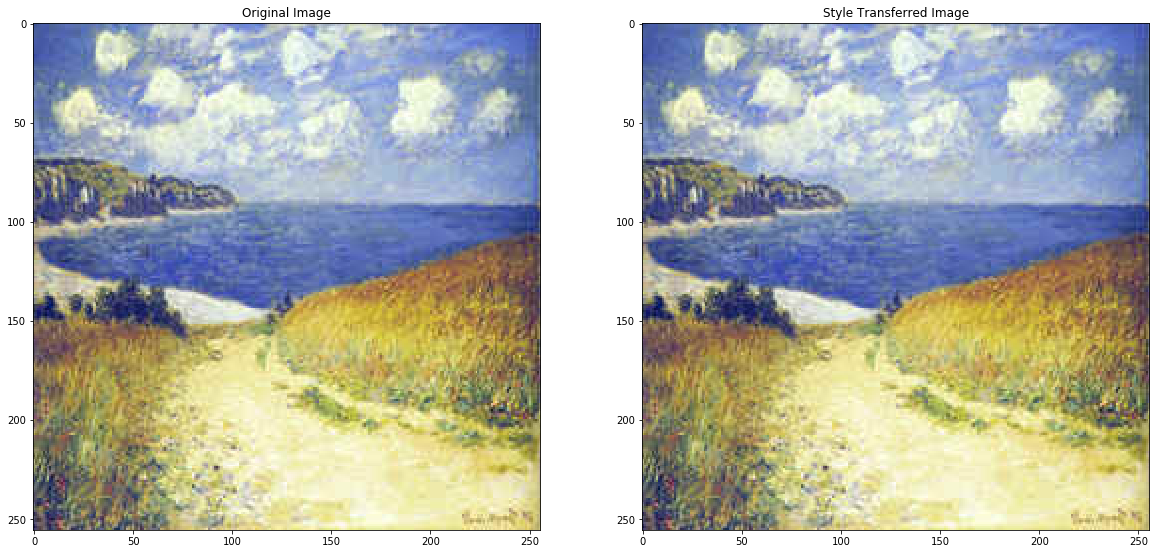

In [39]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(img)
plt.title('Style Transferred Image')